# Simple Fake News Classifier

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Data

In [2]:
# Loading data
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Cleaning & Processing

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,BREAKING! Refugee Terrorist Coverup: Obama’s D...,Federal lawmakers are investigating how a form...,politics,"Mar 9, 2017",fake
1,HARVARD BULLIED INTO Dropping 80 Year Old “Rac...,Harvard is agreeing to erase the history of th...,left-news,"Mar 16, 2016",fake
2,REPUBLICAN TURNS TABLES ON FBI: Deputy Directo...,GCHQ director Robert Hannigan is stepping dow...,politics,"Apr 2, 2017",fake
3,Trump Just Got His P*ssy Handed To Him By New...,Donald Trump bit off a bit more than he could ...,News,"November 17, 2017",fake
4,Trump's debate sniffs take off on social media,NEW YORK (Reuters) - Republican White House ca...,politicsNews,"September 27, 2016",true


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,BREAKING! Refugee Terrorist Coverup: Obama’s D...,Federal lawmakers are investigating how a form...,politics,fake
1,HARVARD BULLIED INTO Dropping 80 Year Old “Rac...,Harvard is agreeing to erase the history of th...,left-news,fake
2,REPUBLICAN TURNS TABLES ON FBI: Deputy Directo...,GCHQ director Robert Hannigan is stepping dow...,politics,fake
3,Trump Just Got His P*ssy Handed To Him By New...,Donald Trump bit off a bit more than he could ...,News,fake
4,Trump's debate sniffs take off on social media,NEW YORK (Reuters) - Republican White House ca...,politicsNews,true


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Federal lawmakers are investigating how a form...,politics,fake
1,Harvard is agreeing to erase the history of th...,left-news,fake
2,GCHQ director Robert Hannigan is stepping dow...,politics,fake
3,Donald Trump bit off a bit more than he could ...,News,fake
4,NEW YORK (Reuters) - Republican White House ca...,politicsNews,true


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,federal lawmakers are investigating how a form...,politics,fake
1,harvard is agreeing to erase the history of th...,left-news,fake
2,gchq director robert hannigan is stepping dow...,politics,fake
3,donald trump bit off a bit more than he could ...,News,fake
4,new york (reuters) - republican white house ca...,politicsNews,true


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

In [13]:
data['text'] = data['text'].apply(punctuation_removal)

In [14]:
# Check
data.head()

,text,subject,target
0,federal lawmakers are investigating how a form...,politics,fake
1,harvard is agreeing to erase the history of th...,left-news,fake
2,gchq director robert hannigan is stepping dow...,politics,fake
3,donald trump bit off a bit more than he could ...,News,fake
4,new york reuters republican white house candi...,politicsNews,true


In [16]:
# For removing stop words
# if not installed: conda install -c anaconda nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/hasan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# Removing stopwords
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data.head()

,text,subject,target
0,federal lawmakers investigating former iraqi i...,politics,fake
1,harvard agreeing erase history law school foun...,left-news,fake
2,gchq director robert hannigan stepping two yea...,politics,fake
3,donald trump bit bit could chew attempted shoo...,News,fake
4,new york reuters republican white house candid...,politicsNews,true


## Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


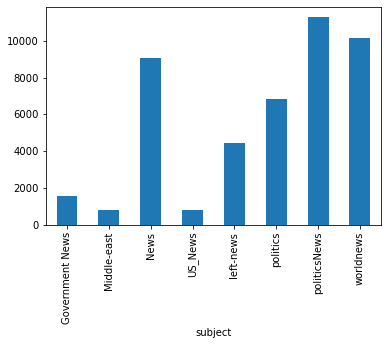

In [18]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


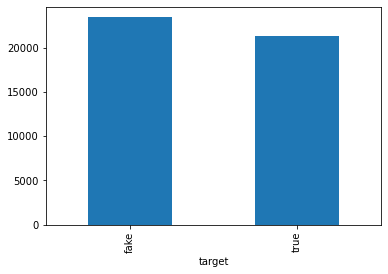

In [19]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [20]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

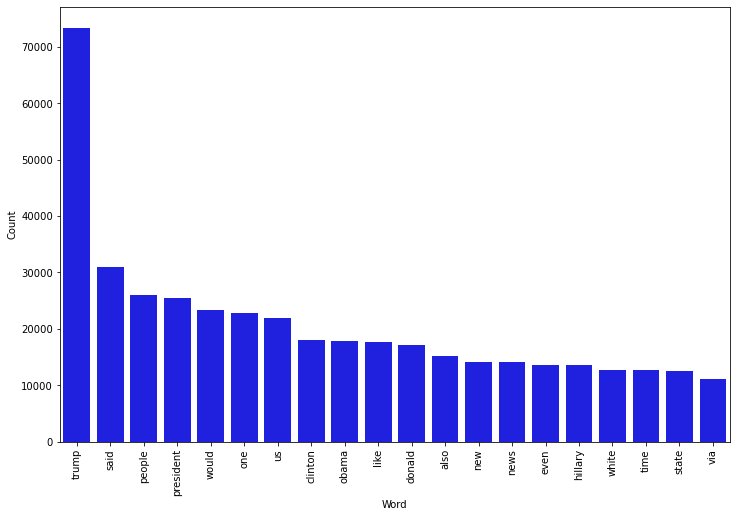

In [21]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

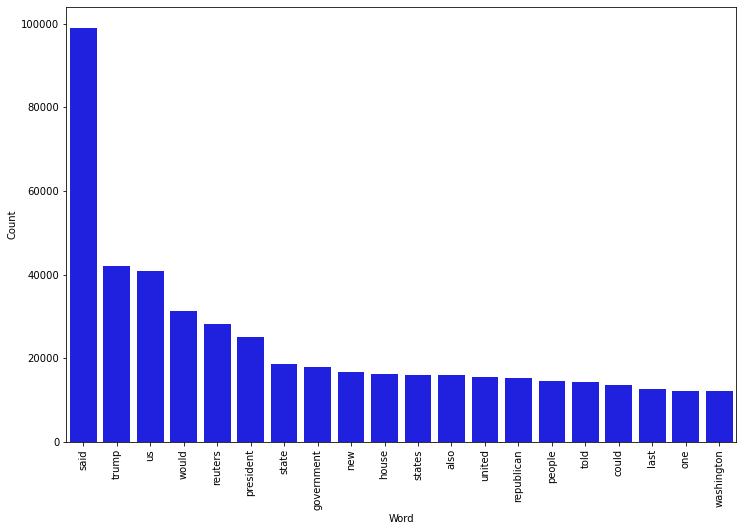

In [22]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [23]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Preparation

In [24]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic Regression

In [25]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

lRpipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
lRmodel = lRpipe.fit(X_train, y_train)

# Accuracy
lRprediction = lRmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, lRprediction)*100,2)))

accuracy: 98.9%


Confusion matrix, without normalization


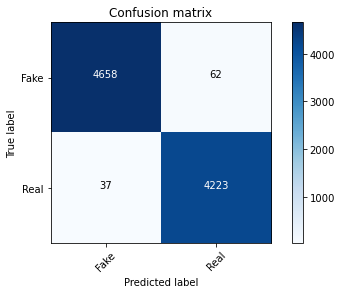

In [26]:
# LR Confusion Matrix
cm = metrics.confusion_matrix(y_test, lRprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
dTpipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
dTmodel = dTpipe.fit(X_train, y_train)

# Accuracy
dTprediction = dTmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, dTprediction)*100,2)))

accuracy: 99.7%


Confusion matrix, without normalization


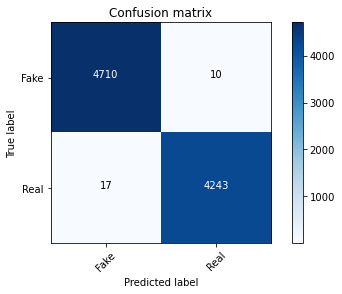

In [29]:
# DT Confusion Matrix
cm = metrics.confusion_matrix(y_test, dTprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

rFpipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

rFmodel = rFpipe.fit(X_train, y_train)
rFprediction = rFmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, rFprediction)*100,2)))

accuracy: 99.18%


Confusion matrix, without normalization


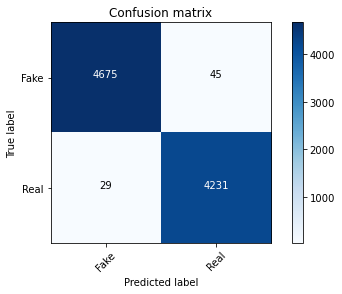

In [31]:
# RF Confusion Matrix
cm = metrics.confusion_matrix(y_test, rFprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

The models have learned to detect fake news with very high accuracy. Need to be tested on real world (unlabeled) data.